Reproduction code for possible bug in pyxem (Tested: pyxem 0.6, commit 79ec2175dea1119d032afd5487a89e28e4aa86c6)

When changing the first euler angle in a rotation list passed to `DiffractionLibraryGenerator::get_diffraction_library`, I expect that only the rotation of the diffraction pattern should change, not the intensities or relative positions of the spots. It is fully possible that I am mistaken, and that the code is correct.

If my expectations are correct, and there actually is a mistake in the code, I think the `DiffractionLibraryGenerator::get_diffraction_library` function passes the wrong matrix to the diffpy `placeInLattice` function, because of a left-handed/right-handed problem. The code below generates the patterns I expect when transposing the rotation matrix, changing

    latt_rot = diffpy.structure.lattice.Lattice(a,b,c,alpha,beta,gamma,baserot=matrix)

to

    latt_rot = diffpy.structure.lattice.Lattice(a,b,c,alpha,beta,gamma,baserot=matrix.T)

I have not compared the implementations of diffpy and pymatgen, but it is quite possible that the bug was introduced during that upgrade.

In [ ]:
#%matplotlib qt
%matplotlib inline
import numpy as np
import pyxem as pxm
from pyxem.libraries.structure_library import StructureLibrary

from diffpy.structure.lattice import Lattice as Lattice
from diffpy.structure.atom import Atom as Atom
from diffpy.structure import Structure as Structure

import matplotlib.pyplot as plt


Generate a rotation list, only changing the first z angle. I think this shouldn't change the diffraction pattern, except for rotating it. Also rotate a fixed angle off the $[001]$ direction.

In [2]:
rotation_list = [(phi, 30, 0) for phi in np.linspace(0, 360, 60)]

Set up a GaAs ZB structure. Any structure should do.

In [3]:
a = 5.75
lattice = Lattice(a, a, a, 90, 90, 90)
atom_list = []
for x, y, z in [(0, 0, 0), (0.5, 0, 0.5), (0, 0.5, 0.5), (0.5, 0.5, 0)]:
    atom_list.append(Atom(atype='Ga', xyz=[x,      y,      z],      lattice=lattice))
    atom_list.append(Atom(atype='As', xyz=[x+0.25, y+0.25, z+0.25], lattice=lattice))
structure = Structure(atoms=atom_list, lattice=lattice)
structure_library = StructureLibrary(
        ['GaAs ZB'],
        [structure],
        [rotation_list])

Mostly arbitrary settings, just to get a reasonable pattern.

In [4]:
gen = pxm.DiffractionGenerator(200, max_excitation_error=1/8)
library_generator = pxm.DiffractionLibraryGenerator(gen)
reciprocal_angstrom_per_pixel = 0.01
size = 256
reciprocal_radius = reciprocal_angstrom_per_pixel*((size // 2) - 1)

diffraction_library = library_generator.get_diffraction_library(
    structure_library,
    calibration=reciprocal_angstrom_per_pixel,
    reciprocal_radius=reciprocal_radius,
    half_shape=(size // 2, size // 2),
    with_direct_beam=False)

Generate images from the pattern library.

In [5]:
patterns = np.empty((len(rotation_list), size, size))
for i in range(len(rotation_list)):
    patterns[i] = diffraction_library['GaAs ZB'][rotation_list[i]]['Sim'].as_signal(size, 0.03, reciprocal_radius)

Inline plot, for easier online viewing. The problem is far easier to see when running this interactively, as below.

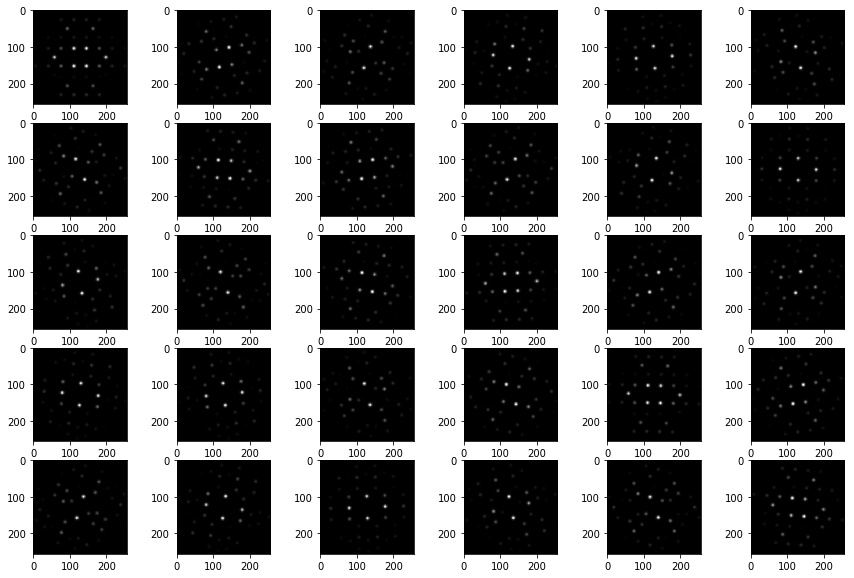

In [6]:
fig = plt.figure(figsize=(15, 10))
for i in range(30):
    plt.subplot(5, 6, i+1)
    plt.imshow(patterns[i*2])

Interactive version

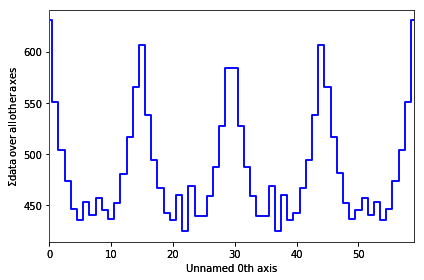

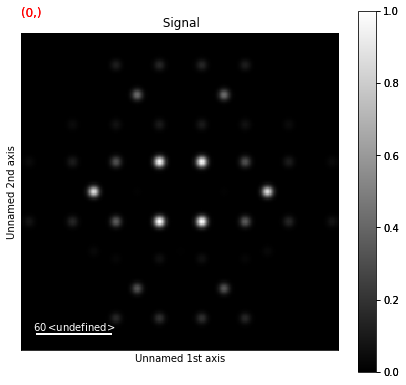

In [7]:
# Requires %matplotlib qt  or  tk  etc.
pxm.ElectronDiffraction(patterns).plot()